# Explicit Rating Recommender (Surprise SVD)

Rebuild the explicit feedback recommender using the Surprise workflow demonstrated in the workshop notebook.


In [1]:
%pip install scikit-surprise


Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


In [3]:
DATA_PATH = Path("data/feedback_explicit.csv")
RATING_SCALE = (1, 5)
TEST_SIZE = 0.1
RANDOM_STATE = 42


def print_stats(frame: pd.DataFrame) -> None:
    """Display dataset cardinality stats."""
    n_users = int(frame["UserID"].nunique())
    n_items = int(frame["ProductCode"].nunique())
    n_ratings = len(frame)
    avg_per_user = n_ratings / n_users if n_users else float("nan")
    print(
        f"users={n_users:6d}, items={n_items:6d}, ratings={n_ratings:6d}, "
        f"avg.ratings/user={avg_per_user:0.1f}"
    )


def load_surprise_dataset(frame: pd.DataFrame) -> Dataset:
    """Convert explicit feedback data into a Surprise dataset."""
    reader = Reader(rating_scale=RATING_SCALE)
    return Dataset.load_from_df(frame[["UserID", "ProductCode", "Rating"]], reader)


def describe_split(trainset, testset) -> None:
    """Print summary stats for the Surprise train/test split."""
    avg_per_user = (
        trainset.n_ratings / trainset.n_users if trainset.n_users else float("nan")
    )
    print(
        "trainset: users=%d, items=%d, ratings=%d, avg.ratings/user=%0.1f, testset len=%d"
        % (
            trainset.n_users,
            trainset.n_items,
            trainset.n_ratings,
            avg_per_user,
            len(testset),
        )
    )


In [4]:
ratings_df = pd.read_csv(DATA_PATH)
ratings_df["Rating"] = pd.to_numeric(ratings_df["Rating"], downcast="float")
print_stats(ratings_df)
ratings_df.head()


users=  5000, items= 14163, ratings= 30136, avg.ratings/user=6.0


,UserID,ProductCode,Rating
0,43bfd397-c07c-4859-8c37-3a4e4aa1b945,3452200004079,5.0
1,43bfd397-c07c-4859-8c37-3a4e4aa1b945,2609842031098,4.0
2,43bfd397-c07c-4859-8c37-3a4e4aa1b945,3700036905900,4.0
3,faaf0310-7d9f-433b-88e3-15e6eaf95676,0041190069613,5.0
4,faaf0310-7d9f-433b-88e3-15e6eaf95676,8901262173605,3.0


In [5]:
data = load_surprise_dataset(ratings_df)
trainset, testset = train_test_split(data, test_size=TEST_SIZE)
describe_split(trainset, testset)


trainset: users=4998, items=13238, ratings=27122, avg.ratings/user=5.4, testset len=3014


In [6]:
algo = SVD(n_factors=50, random_state=RANDOM_STATE)
algo.fit(trainset)


In [7]:
predictions = algo.test(testset)
mae = accuracy.mae(predictions, verbose=False)
print(f"MAE: {mae:.4f}")


MAE: 0.7096


In [8]:
def get_top_n(predictions: Iterable, n: int = 10) -> Dict[str, List[Tuple[str, float]]]:
    """Return the top-n item predictions per user."""
    top_n: Dict[str, List[Tuple[str, float]]] = defaultdict(list)
    for uid, iid, _true_r, est, _ in predictions:
        user_key = str(uid)
        item_key = str(iid)
        top_n[user_key].append((item_key, est))
    for user_key, user_ratings in top_n.items():
        user_ratings.sort(key=lambda pair: pair[1], reverse=True)
        top_n[user_key] = user_ratings[:n]
    return top_n


In [9]:
sample_inner_uid = next(iter(trainset.all_users()))
target_user = str(trainset.to_raw_uid(sample_inner_uid))

anti_testset = trainset.build_anti_testset()
target_unrated = [row for row in anti_testset if row[0] == target_user]
target_predictions = algo.test(target_unrated)
top_recs = get_top_n(target_predictions, n=10)

print("pred.rating\titem_id")
for item_id, score in top_recs.get(target_user, []):
    print(f"{score:0.4f}\t{item_id}")


pred.rating	item_id
4.5633	5601312008989
4.5466	20231293
4.5298	7502252482694
4.5272	00961035
4.5260	4260363482356
4.5245	9344062349716
4.5243	8480010000221
4.5178	8006040255150
4.5112	3760187531052
4.4958	4337256973854


In [10]:
def precision_recall_at_k(
    predictions: Iterable,
    k: int = 10,
    threshold: float = 4.0,
    get_means: bool = False,
) -> Tuple[Dict[int, float], Dict[int, float]]:
    """Compute precision@k and recall@k for each user."""
    user_est_true: Dict[str, List[Tuple[float, float]]] = defaultdict(list)
    for uid, _iid, true_r, est, _ in predictions:
        user_est_true[str(uid)].append((est, true_r))

    precisions: Dict[int, float] = {}
    recalls: Dict[int, float] = {}
    total_rel = 0
    total_rel_and_rec_k = 0
    total_rec_k = 0

    for idx_user, user_ratings in enumerate(user_est_true.values()):
        user_ratings.sort(key=lambda pair: pair[0], reverse=True)
        n_rel = sum(true_r >= threshold for _est, true_r in user_ratings)
        n_rec_k = sum(est >= threshold for est, _true_r in user_ratings[:k])
        n_rel_and_rec_k = sum(
            (true_r >= threshold) and (est >= threshold)
            for est, true_r in user_ratings[:k]
        )
        precisions[idx_user] = n_rel_and_rec_k / n_rec_k if n_rec_k else np.nan
        recalls[idx_user] = n_rel_and_rec_k / n_rel if n_rel else np.nan
        total_rel += n_rel
        total_rel_and_rec_k += n_rel_and_rec_k
        total_rec_k += n_rec_k

    if get_means:
        precisions = {
            0: (float(total_rel_and_rec_k) / total_rec_k) if total_rec_k else np.nan
        }
        recalls = {
            0: (float(total_rel_and_rec_k) / total_rel) if total_rel else np.nan
        }

    return precisions, recalls


def mean_average_precision_at_k(
    model: SVD,
    evalset: Iterable[tuple[str, str, float]],
    k: int = 10,
    threshold: float = 4.0,
    predictions: Optional[Iterable] = None,
) -> float:
    """Compute MAP@k for a Surprise model over the given evalset."""
    eval_list = list(evalset)
    if not eval_list:
        return float("nan")
    if predictions is None:
        predictions_list = list(model.test(eval_list))
    else:
        predictions_list = list(predictions)
    predictions_by_user: Dict[str, List[tuple[str, float, float]]] = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions_list:
        predictions_by_user[str(uid)].append((str(iid), float(est), float(true_r)))
    ap_scores: List[float] = []
    for user_predictions in predictions_by_user.values():
        user_predictions.sort(key=lambda entry: entry[1], reverse=True)
        hits = 0
        score_sum = 0.0
        for rank, (_, _score, true_r) in enumerate(user_predictions[:k], start=1):
            if true_r >= threshold:
                hits += 1
                score_sum += hits / rank
        if hits:
            ap_scores.append(score_sum / hits)
    return float(np.mean(ap_scores)) if ap_scores else float("nan")


def svd_factor_search(
    data: Dataset,
    k: int,
    factor_grid: Iterable[int],
    test_size: float = TEST_SIZE,
    like_threshold: float = 4.0,
    repeats: int = 5,
) -> List[Dict[str, float]]:
    """Evaluate SVD factor counts using MAE, Precision@K, Recall@K, and MAP@K."""
    results: List[Dict[str, float]] = []
    for n_factors in factor_grid:
        mae_scores: List[float] = []
        p_at_k_scores: List[float] = []
        r_at_k_scores: List[float] = []
        map_scores: List[float] = []
        for _ in range(repeats):
            trainset_split, testset_split = train_test_split(data, test_size=test_size)
            algo_split = SVD(n_factors=n_factors, random_state=RANDOM_STATE)
            algo_split.fit(trainset_split)
            predictions_split = algo_split.test(testset_split)
            precisions, recalls = precision_recall_at_k(
                predictions_split,
                k=k,
                threshold=like_threshold,
                get_means=True,
            )
            mae_scores.append(accuracy.mae(predictions_split, verbose=False))
            p_at_k_scores.append(np.nanmean(list(precisions.values())))
            r_at_k_scores.append(np.nanmean(list(recalls.values())))
            map_scores.append(
                mean_average_precision_at_k(
                    algo_split,
                    testset_split,
                    k=k,
                    threshold=like_threshold,
                    predictions=predictions_split,
                )
            )
        results.append(
            {
                "n_factors": float(n_factors),
                "mae": float(np.nanmean(mae_scores)),
                "p_at_k": float(np.nanmean(p_at_k_scores)),
                "r_at_k": float(np.nanmean(r_at_k_scores)),
                "map_at_k": float(np.nanmean(map_scores)),
            }
        )
        print(
            "f=%3d MAE: %0.4f P@K: %0.4f R@K: %0.4f MAP@K: %0.4f"
            % (
                n_factors,
                np.nanmean(mae_scores),
                np.nanmean(p_at_k_scores),
                np.nanmean(r_at_k_scores),
                np.nanmean(map_scores),
            )
        )
    return results


def grid_search_svd(
    trainset,
    evalset: Iterable[tuple[str, str, float]],
    param_grid: Dict[str, Iterable],
    k: int = 10,
    threshold: float = 4.0,
) -> pd.DataFrame:
    """Grid search SVD hyperparameters scored by MAP@k."""
    eval_list = list(evalset)
    if not eval_list:
        return pd.DataFrame()
    param_names = list(param_grid.keys())
    records: List[Dict[str, float]] = []
    for combo in product(*(param_grid[name] for name in param_names)):
        params = dict(zip(param_names, combo))
        algo = SVD(random_state=RANDOM_STATE, **params)
        algo.fit(trainset)
        predictions = algo.test(eval_list)
        mae_score = accuracy.mae(predictions, verbose=False)
        map_score = mean_average_precision_at_k(
            algo,
            eval_list,
            k=k,
            threshold=threshold,
            predictions=predictions,
        )
        record = {**params, "mae": float(mae_score), f"MAP@{k}": float(map_score)}
        records.append(record)
    return pd.DataFrame(records)


In [11]:
train_evalset = trainset.build_testset()
map_train = mean_average_precision_at_k(
    algo, train_evalset, k=10, threshold=4.0
)
map_test = mean_average_precision_at_k(
    algo, testset, k=10, threshold=4.0
)
print(f"MAP@10 (Train): {map_train:.4f}")
print(f"MAP@10 (Test): {map_test:.4f}")


MAP@10 (Train): 0.9640
MAP@10 (Test): 0.9573


In [12]:
factor_grid = [10, 25, 50, 75, 100]
evaluation_results = svd_factor_search(
    data,
    k=10,
    factor_grid=factor_grid,
    test_size=TEST_SIZE,
    like_threshold=4.0,
    repeats=5,
)
results_df = pd.DataFrame(evaluation_results)
results_df


f= 10 MAE: 0.7094 P@K: 0.6657 R@K: 0.5085 MAP@K: 0.9584
f= 25 MAE: 0.7082 P@K: 0.6801 R@K: 0.5099 MAP@K: 0.9584
f= 50 MAE: 0.7133 P@K: 0.6757 R@K: 0.5088 MAP@K: 0.9552
f= 75 MAE: 0.7085 P@K: 0.6738 R@K: 0.5110 MAP@K: 0.9534
f=100 MAE: 0.7149 P@K: 0.6625 R@K: 0.5008 MAP@K: 0.9566


,n_factors,mae,p_at_k,r_at_k,map_at_k
0,10.0,0.709419,0.665720,0.508547,0.958378
1,25.0,0.708212,0.680146,0.509877,0.958415
2,50.0,0.713269,0.675711,0.508762,0.955232
3,75.0,0.708482,0.673819,0.511041,0.953351
4,100.0,0.714949,0.662495,0.500814,0.956650


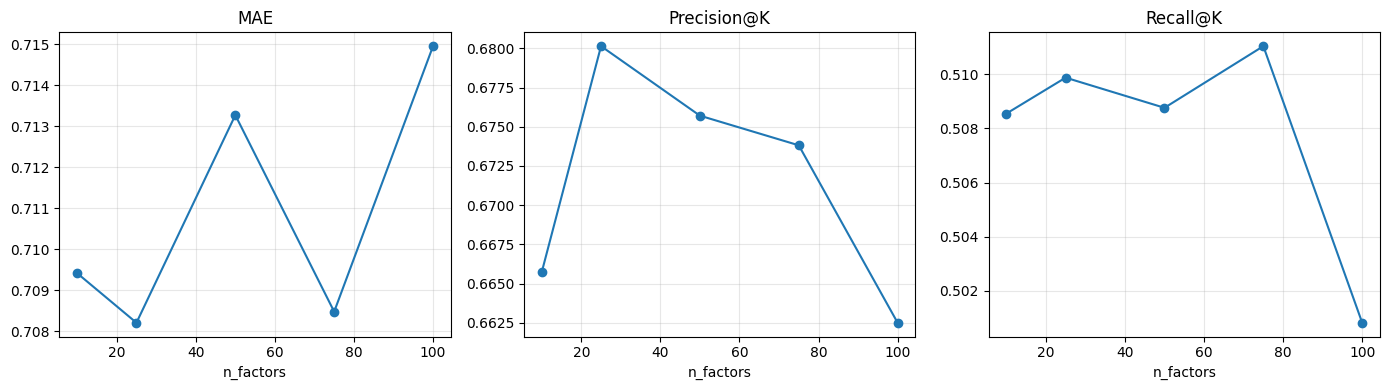

In [13]:
def plot_metric_trends(results: pd.DataFrame) -> None:
    """Plot metric trends across latent factor values."""
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    metrics = [("mae", "MAE"), ("p_at_k", "Precision@K"), ("r_at_k", "Recall@K")]
    for ax, (column, label) in zip(axes, metrics, strict=False):
        ax.plot(results["n_factors"], results[column], marker="o")
        ax.set_xlabel("n_factors")
        ax.set_title(label)
        ax.grid(True, alpha=0.3)
    plt.tight_layout()


plot_metric_trends(results_df)


In [14]:
param_grid = {
    "n_factors": [25, 50, 75],
    "n_epochs": [20, 40, 60],
    "lr_all": [0.005, 0.01],
    "reg_all": [0.02, 0.05],
}

grid_results = grid_search_svd(
    trainset,
    testset,
    param_grid,
    k=10,
    threshold=4.0,
)
grid_results.sort_values("MAP@10", ascending=False).reset_index(drop=True)


,n_factors,n_epochs,lr_all,reg_all,mae,MAP@10
0,75,40,0.010,0.02,0.749686,0.961915
1,75,60,0.010,0.05,0.754736,0.961617
2,75,60,0.005,0.05,0.741410,0.961468
3,75,60,0.010,0.02,0.756122,0.961419
4,75,40,0.010,0.05,0.748270,0.961419
5,75,60,0.005,0.02,0.742744,0.961071
6,75,40,0.005,0.05,0.730196,0.960426
7,75,20,0.005,0.02,0.710560,0.960277
8,75,20,0.010,0.05,0.730511,0.960029
9,75,20,0.005,0.05,0.710020,0.959979


In [15]:
if grid_results.empty:
    raise ValueError("Grid search returned no results.")
best_row = grid_results.sort_values("MAP@10", ascending=False).iloc[0]
best_params = {
    "n_factors": int(best_row["n_factors"]),
    "n_epochs": int(best_row["n_epochs"]),
    "lr_all": float(best_row["lr_all"]),
    "reg_all": float(best_row["reg_all"]),
}
best_params


{'n_factors': 75, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}

In [16]:
final_model = SVD(
    n_factors=best_params["n_factors"],
    n_epochs=best_params["n_epochs"],
    lr_all=best_params["lr_all"],
    reg_all=best_params["reg_all"],
    random_state=RANDOM_STATE,
)
final_model.fit(trainset)


In [17]:
final_predictions = final_model.test(testset)
final_mae = accuracy.mae(final_predictions, verbose=False)
final_map = mean_average_precision_at_k(
    final_model,
    testset,
    k=10,
    threshold=4.0,
    predictions=final_predictions,
)
print(f"Final model MAE: {final_mae:.4f}")
print(f"Final model MAP@10: {final_map:.4f}")


Final model MAE: 0.7497
Final model MAP@10: 0.9619


In [18]:
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# Refit on the entire dataset before persisting the model.
full_trainset = data.build_full_trainset()
final_model.fit(full_trainset)

with open(model_dir / "explicit_recommender_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Saved best SVD model to model/explicit_recommender_model.pkl")


Saved best SVD model to model/explicit_recommender_model.pkl
